# Multiclass Text Classification with 
# Feed-forward Neural Networks and Word Embeddings

First, we will do some initialization.

In [ ]:
# importamos las librerias necesarias
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu') # seleccionamos el gpu si esta disponible, si no, seleccionamos la cpu
print(f'device: {device.type}') # imprimimos el tipo de dispositivo que seleccionamos

# random seed
seed = 1234

# set random seed
if seed is not None: # si el valor de la semilla no es nulo
    print(f'random seed: {seed}') # imprimimos el valor de la semilla
    random.seed(seed) # fijamos la semilla para random 
    np.random.seed(seed) # fijamos la semilla para numpy
    torch.manual_seed(seed) # fijamos la semilla para torch

device: cpu
random seed: 1234


We will be using the AG's News Topic Classification Dataset.
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict.

First, we will load the training dataset using [pandas](https://pandas.pydata.org/) and take a quick look at how the data.

In [ ]:
train_df = pd.read_csv('./train.csv', header=None) # leemos el archivo train.csv, que contiene los datos de entrenamiento
train_df.columns = ['class index', 'title', 'description'] # renombramos las columnas del dataframe
train_df # mostramos el dataframe

,class index,title,description
0,Class Index,Title,Description
1,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
...,...,...,...
119996,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119997,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119998,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119999,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


The dataset consists of 120,000 examples, each consisting of a class index, a title, and a description.
The class labels are distributed in a separated file. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [ ]:
labels = open('./classes.txt').read().splitlines() # leemos el archivo classes.txt, que contiene las etiquetas de las clases
train_df = train_df.drop(0).reset_index(drop=True) # eliminamos la primera fila del dataframe 
train_df['class index'] = train_df['class index'].astype(int) # convertimos la columna 'class index' a tipo entero
classes = train_df['class index'].map(lambda i: labels[i-1]) # mapeamos los indices de las clases a las etiquetas correspondientes
train_df.insert(1, 'class', classes) # insertamos la columna 'class' en la posicion 1 del dataframe
train_df # mostramos el dataframe

,class index,class,title,description
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Let's inspect how balanced our examples are by using a bar plot.

/var/folders/7b/g3f6kzfd1b99b918vd8tvd100000gn/T/ipykernel_47998/1245903889.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_df['class']).plot.bar()


<Axes: xlabel='class'>

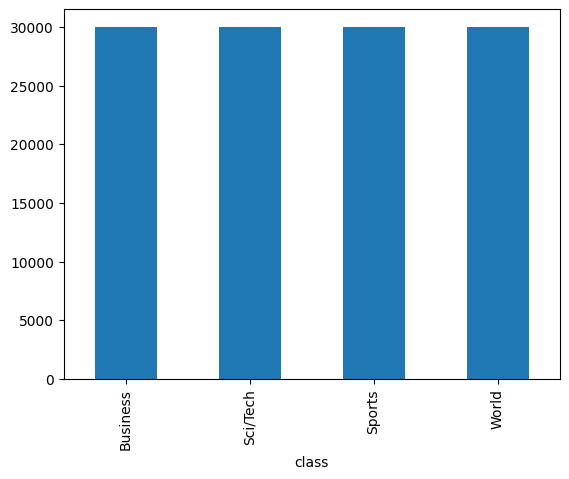

In [ ]:
pd.value_counts(train_df['class']).plot.bar() # graficamos la distribucion de las clases

The classes are evenly distributed. That's great!

However, the text contains some spurious backslashes in some parts of the text.
They are meant to represent newlines in the original text.
An example can be seen below, between the words "dwindling" and "band".

In [ ]:
print(train_df.loc[0, 'description']) # imprimimos la descripcion de la primera fila del dataframe

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method.

In [ ]:
train_df['text'] = train_df['title'].str.lower() + " " + train_df['description'].str.lower() # concatenamos las columnas 'title' y 'description' en una nueva columna 'text'
train_df['text'] = train_df['text'].str.replace('\\', ' ', regex=False) # reemplazamos los caracteres '\' por ' ' en la columna 'text' 
train_df # mostramos el dataframe

,class index,class,title,description,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [ ]:
from nltk.tokenize import word_tokenize # importamos la funcion word_tokenize de la libreria nltk

train_df['tokens'] = train_df['text'].progress_map(word_tokenize) # tokenizamos la columna 'text' y guardamos los tokens en la columna 'tokens'
train_df # mostramos el dataframe

  0%|          | 0/120000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...,"[wall, st., bears, claw, back, into, the, blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...,"[oil, and, economy, cloud, stocks, ', outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p..."
...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...,"[pakistan, 's, musharraf, says, wo, n't, quit,..."
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...,"[renteria, signing, a, top-shelf, deal, red, s..."
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...,"[saban, not, going, to, dolphins, yet, the, mi..."
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...,"[today, 's, nfl, games, pittsburgh, at, ny, gi..."


Now we will load the GloVe word embeddings.

In [ ]:
from gensim.models import KeyedVectors # importamos la clase KeyedVectors de la libreria gensim
glove = KeyedVectors.load_word2vec_format("./glove.6B.300d.txt", no_header=True) # cargamos el modelo pre-entrenado glove.6B.300d.txt
glove.vectors.shape # imprimimos la forma de la matriz de vectores del modelo

(400000, 300)

The word embeddings have been pretrained in a different corpus, so it would be a good idea to estimate how good our tokenization matches the GloVe vocabulary.

In [ ]:
from collections import Counter # importamos la clase Counter de la libreria collections

def count_unknown_words(data, vocabulary): # definimos la funcion count_unknown_words
    counter = Counter() # inicializamos un contador
    for row in tqdm(data): # iteramos sobre las filas de los datos
        counter.update(tok for tok in row if tok not in vocabulary) # actualizamos el contador con los tokens que no estan en el vocabulario
    return counter # retornamos el contador

# find out how many times each unknown token occurrs in the corpus
c = count_unknown_words(train_df['tokens'], glove.key_to_index) # contamos cuantas veces aparece cada token desconocido en el corpus

# find the total number of tokens in the corpus
total_tokens = train_df['tokens'].map(len).sum() # contamos el numero total de tokens en el corpus

# find some statistics about occurrences of unknown tokens
unk_tokens = sum(c.values()) # contamos el numero total de tokens desconocidos
percent_unk = unk_tokens / total_tokens # calculamos el porcentaje de tokens desconocidos
distinct_tokens = len(list(c)) # contamos el numero de tokens desconocidos distintos

print(f'total number of tokens: {total_tokens:,}') # imprimimos el numero total de tokens
print(f'number of unknown tokens: {unk_tokens:,}') # imprimimos el numero de tokens desconocidos
print(f'number of distinct unknown tokens: {distinct_tokens:,}') # imprimimos el numero de tokens desconocidos distintos
print(f'percentage of unkown tokens: {percent_unk:.2%}') # imprimimos el porcentaje de tokens desconocidos
print('top 50 unknown words:') # imprimimos los 50 tokens desconocidos mas comunes
for token, n in c.most_common(10): # iteramos sobre los 50 tokens desconocidos mas comunes
    print(f'\t{n}\t{token}') # imprimimos el token y el numero de veces que aparece

  0%|          | 0/120000 [00:00<?, ?it/s]

total number of tokens: 5,273,364
number of unknown tokens: 65,817
number of distinct unknown tokens: 24,621
percentage of unkown tokens: 1.25%
top 50 unknown words:
	2984	/b
	2119	href=
	2117	/a
	1813	//www.investor.reuters.com/fullquote.aspx
	1813	target=/stocks/quickinfo/fullquote
	537	/p
	510	newsfactor
	471	cbs.mw
	431	color=
	417	/font


Glove embeddings seem to have a good coverage on this dataset -- only 1.25% of the tokens in the dataset are unknown, i.e., don't appear in the GloVe vocabulary.

Still, we will need a way to handle these unknown tokens.
Our approach will be to add a new embedding to GloVe that will be used to represent them.
This new embedding will be initialized as the average of all the GloVe embeddings.

We will also add another embedding, this one initialized to zeros, that will be used to pad the sequences of tokens so that they all have the same length. This will be useful when we train with mini-batches.

In [ ]:
# string values corresponding to the new embeddings
unk_tok = '[UNK]' # estos son los tokens que representan los embeddings desconocidos y de padding
pad_tok = '[PAD]' # este ultimo se utiliza para rellenar las secuencias

# initialize the new embedding values
unk_emb = glove.vectors.mean(axis=0) # inicializamos los embeddings desconocidos con el promedio de los embeddings del modelo
pad_emb = np.zeros(300) # inicializamos los embeddings de padding con ceros

# add new embeddings to glove
glove.add_vectors([unk_tok, pad_tok], [unk_emb, pad_emb]) # agregamos los nuevos embeddings al modelo

# get token ids corresponding to the new embeddings
unk_id = glove.key_to_index[unk_tok] # obtenemos el id del token de unknown
pad_id = glove.key_to_index[pad_tok] # obtenemos el id del token de padding

unk_id, pad_id # imprimimos los ids de los tokens de unknown y padding

(400000, 400001)

In [ ]:
from sklearn.model_selection import train_test_split # importamos la funcion train_test_split de la libreria sklearn

train_df, dev_df = train_test_split(train_df, train_size=0.8) # dividimos el dataframe en datos de entrenamiento y validacion
train_df.reset_index(inplace=True) # reseteamos los indices del dataframe de entrenamiento
dev_df.reset_index(inplace=True) # reseteamos los indices del dataframe de validacion

We will now add a new column to our dataframe that will contain the padded sequences of token ids.

In [ ]:
threshold = 10 # definimos un umbral para filtrar los tokens menos comunes
tokens = train_df['tokens'].explode().value_counts() # contamos cuantas veces aparece cada token en el corpus 
vocabulary = set(tokens[tokens > threshold].index.tolist()) # filtramos los tokens que aparecen mas de 'threshold' veces y los guardamos en un conjunto
print(f'vocabulary size: {len(vocabulary):,}') # imprimimos el tamaño del vocabulario

vocabulary size: 17,445


In [ ]:
# find the length of the longest list of tokens
max_tokens = train_df['tokens'].map(len).max() # calculamos la longitud de la lista de tokens mas larga

# return unk_id for infrequent tokens too
def get_id(tok): # definimos la funcion get_id
    if tok in vocabulary: # si el token esta en el vocabulario 
        return glove.key_to_index.get(tok, unk_id) # retornamos el id del token, si no esta en el vocabulario retornamos el id del token de unknown
    else: 
        return unk_id # si el token no esta en el vocabulario retornamos el id del token de unknown

# function that gets a list of tokens and returns a list of token ids,
# with padding added accordingly
def token_ids(tokens): # definimos la funcion token_ids
    tok_ids = [get_id(tok) for tok in tokens] # obtenemos los ids de los tokens
    pad_len = max_tokens - len(tok_ids) # calculamos la longitud del padding
    return tok_ids + [pad_id] * pad_len # retornamos los ids de los tokens con padding

# add new column to the dataframe
train_df['token ids'] = train_df['tokens'].progress_map(token_ids) #  mapeamos los tokens a sus ids y los guardamos en la columna 'token ids' 
train_df # mostramos el dataframe

  0%|          | 0/96000 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens,token ids
0,9116,1,World,Najaf's Residents Feel Trapped in Battle (AP),"AP - For nearly three weeks, Amer al-Jamali ha...",najaf's residents feel trapped in battle (ap) ...,"[najaf, 's, residents, feel, trapped, in, batt...","[10709, 9, 1048, 998, 4799, 6, 903, 23, 1582, ..."
1,99831,3,Business,U.S. FDA Adds Restrictions to Acne Drug,WASHINGTON (Reuters) - Roche's acne drug Accu...,u.s. fda adds restrictions to acne drug washi...,"[u.s., fda, adds, restrictions, to, acne, drug...","[99, 5584, 2144, 3252, 4, 400000, 780, 289, 23..."
2,10663,3,Business,Smithfield Foods Profit More Than Doubles,"Smithfield Foods Inc. (SFD.N: Quote, Profile, ...",smithfield foods profit more than doubles smit...,"[smithfield, foods, profit, more, than, double...","[34026, 5008, 1269, 56, 73, 4229, 34026, 5008,..."
3,73175,4,Sci/Tech,PluggedIn: The OQO Is Not Just Another Handhel...,SAN FRANCISCO (Reuters) - A full-fledged Wind...,pluggedin: the oqo is not just another handhel...,"[pluggedin, :, the, oqo, is, not, just, anothe...","[400000, 45, 0, 293697, 14, 36, 120, 170, 2099..."
4,104494,4,Sci/Tech,IBM invigorates LTO tape storage,LTO (linear tape open)-based drives are invigo...,ibm invigorates lto tape storage lto (linear t...,"[ibm, invigorates, lto, tape, storage, lto, (,...","[5199, 400000, 400000, 4143, 4418, 400000, 23,..."
...,...,...,...,...,...,...,...,...
95995,89460,1,World,"Bush, Blair See Hope for Palestinian State (AP)","AP - As Yasser Arafat was buried, President Bu...","bush, blair see hope for palestinian state (ap...","[bush, ,, blair, see, hope, for, palestinian, ...","[272, 1, 2356, 253, 824, 10, 463, 92, 23, 1582..."
95996,60620,1,World,Ex-Soldiers Vow to Bring Order to Haiti Capital,Ex-soldiers who helped topple former President...,ex-soldiers vow to bring order to haiti capita...,"[ex-soldiers, vow, to, bring, order, to, haiti...","[223970, 12887, 4, 938, 460, 4, 3836, 351, 223..."
95997,34086,1,World,Musharraf says U.S. must address root of terro...,Reuters - The United States could lose its war...,musharraf says u.s. must address root of terro...,"[musharraf, says, u.s., must, address, root, o...","[3820, 210, 99, 390, 1476, 5440, 3, 1291, 23, ..."
95998,58067,1,World,Nuclear materials #39;vanish #39; in Iraq,Equipment and materials that could be used to ...,nuclear materials #39;vanish #39; in iraq equ...,"[nuclear, materials, #, 39, ;, vanish, #, 39, ...","[490, 2176, 2749, 3403, 89, 25736, 2749, 3403,..."


In [ ]:
max_tokens = dev_df['tokens'].map(len).max() # calculamos la longitud de la lista de tokens mas larga en el dataframe de validacion
dev_df['token ids'] = dev_df['tokens'].progress_map(token_ids) # mapeamos los tokens a sus ids y los guardamos en la columna 'token ids'
dev_df # mostramos el dataframe

  0%|          | 0/24000 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens,token ids
0,60974,1,World,Sharon Accepts Plan to Reduce Gaza Army Operat...,Israeli Prime Minister Ariel Sharon accepted a...,sharon accepts plan to reduce gaza army operat...,"[sharon, accepts, plan, to, reduce, gaza, army...","[2548, 9889, 394, 4, 1680, 1166, 330, 957, 1, ..."
1,50391,4,Sci/Tech,Internet Key Battleground in Wildlife Crime Fight,Why trawl through a sweaty illegal\wildlife ma...,internet key battleground in wildlife crime fi...,"[internet, key, battleground, in, wildlife, cr...","[925, 638, 14944, 6, 4446, 1340, 838, 738, 400..."
2,9307,3,Business,July Durable Good Orders Rise 1.7 Percent,America's factories saw orders for costly manu...,july durable good orders rise 1.7 percent amer...,"[july, durable, good, orders, rise, 1.7, perce...","[375, 10699, 219, 1949, 1027, 6262, 72, 453, 9..."
3,35221,3,Business,Growing Signs of a Slowing on Wall Street,"all Street #39;s earnings growth, fueled by tw...",growing signs of a slowing on wall street all ...,"[growing, signs, of, a, slowing, on, wall, str...","[988, 1867, 3, 7, 6515, 13, 1015, 491, 64, 491..."
4,40081,1,World,The New Faces of Reality TV,The introduction of children to the genre was ...,the new faces of reality tv the introduction o...,"[the, new, faces, of, reality, tv, the, introd...","[0, 50, 1919, 3, 2532, 816, 0, 4344, 3, 271, 4..."
...,...,...,...,...,...,...,...,...
23995,49572,1,World,Iraqi Kidnappers Release 2 Indonesian Women,Two Indonesian women held hostage for several ...,iraqi kidnappers release 2 indonesian women tw...,"[iraqi, kidnappers, release, 2, indonesian, wo...","[710, 9349, 713, 232, 2656, 266, 55, 2656, 266..."
23996,40409,4,Sci/Tech,Big Wi-Fi Project for Philadelphia,What would Benjamin Franklin say? Philadelphia...,big wi-fi project for philadelphia what would ...,"[big, wi-fi, project, for, philadelphia, what,...","[365, 39300, 716, 10, 2201, 102, 54, 4067, 503..."
23997,70470,2,Sports,Owen scores again,Michael Owen scored the winner for Real Madrid...,owen scores again michael owen scored the winn...,"[owen, scores, again, michael, owen, scored, t...","[7116, 2776, 378, 785, 7116, 878, 0, 1364, 10,..."
23998,7941,4,Sci/Tech,US Online Retail Sales Expected To Double In S...,Online retail sales in the US are expected to ...,us online retail sales expected to double in s...,"[us, online, retail, sales, expected, to, doub...","[95, 1292, 2645, 526, 287, 4, 1278, 6, 228, 82..."


Now we will get a numpy 2-dimensional array corresponding to the token ids,
and a 1-dimensional array with the gold classes. Note that the classes are one-based (i.e., they start at one),
but we need them to be zero-based, so we need to subtract one from this array.

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset): # definimos la clase MyDataset 
    def __init__(self, x, y): # definimos el metodo __init__
        self.x = x # inicializamos el atributo x
        self.y = y # inicializamos el atributo y
        
    def __len__(self): # definimos el metodo __len__
        return len(self.y) # retornamos la longitud del atributo y
     
    def __getitem__(self, index): # definimos el metodo __getitem__
        x = torch.tensor(self.x[index]) # convertimos el atributo x a un tensor de torch
        y = torch.tensor(self.y[index]) # convertimos el atributo y a un tensor de torch
        return x, y # retornamos x e y

Next, we construct our PyTorch model, which is a feed-forward neural network with two layers:

In [ ]:
from torch import nn # importamos el modulo nn de la libreria torch
import torch.nn.functional as F # importamos el modulo functional de la libreria torch

class Model(nn.Module): # definimos la clase Model
    def __init__(self, vectors, pad_id, hidden_dim, output_dim, dropout): #     definimos el metodo __init__
        super().__init__() # inicializamos la clase padre
        # embeddings must be a tensor
        if not torch.is_tensor(vectors): # si los vectores no son un tensor
            vectors = torch.tensor(vectors) # convertimos los vectores a un tensor
        # keep padding id 
        self.padding_idx = pad_id # guardamos el id del padding
        # embedding layer
        self.embs = nn.Embedding.from_pretrained(vectors, padding_idx=pad_id) # inicializamos la capa de embeddings
        # feedforward layers
        self.layers = nn.Sequential( # inicializamos las capas feedforward
            nn.Dropout(dropout), # dropout
            nn.Linear(vectors.shape[1], hidden_dim), # capa lineal
            nn.ReLU(), # funcion de activacion
            nn.Dropout(dropout), # dropout
            nn.Linear(hidden_dim, output_dim), # capa lineal
        )
        
    def forward(self, x):
        # get boolean array with padding elements set to false
        not_padding = torch.isin(x, self.padding_idx, invert=True)
        # get lengths of examples (excluding padding)
        lengths = torch.count_nonzero(not_padding, axis=1)
        # get embeddings
        x = self.embs(x)
        # calculate means
        x = x.sum(dim=1) / lengths.unsqueeze(dim=1)
        # pass to rest of the model
        output = self.layers(x)
        # calculate softmax if we're not in training mode
        #if not self.training:
        #    output = F.softmax(output, dim=1)
        return output 

Next, we implement the training procedure. We compute the loss and accuracy on the development partition after each epoch.

In [ ]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# hyperparameters
lr = 1e-3 # definimos el learning rate
weight_decay = 0 # definimos el weight decay
batch_size = 500 # definimos el tamaño del batch
shuffle = True # definimos si se mezclan los datos
n_epochs = 5 # definimos el numero de epocas
hidden_dim = 50 # definimos la dimension de la capa oculta
output_dim = len(labels) # definimos la dimension de la capa de salida
dropout = 0.1 # definimos el dropout
vectors = glove.vectors # inicializamos los vectores de embeddings

# initialize the model, loss function, optimizer, and data-loader
model = Model(vectors, pad_id, hidden_dim, output_dim, dropout).to(device) # inicializamos el modelo
loss_func = nn.CrossEntropyLoss() # inicializamos la funcion de perdida
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # inicializamos el optimizador
train_ds = MyDataset(train_df['token ids'], train_df['class index'] - 1) # inicializamos el dataset de entrenamiento
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle) # inicializamos el dataloader de entrenamiento
dev_ds = MyDataset(dev_df['token ids'], dev_df['class index'] - 1) # inicializamos el dataset de validacion
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=shuffle) # inicializamos el dataloader de validacion

train_loss = [] 
train_acc = [] 

dev_loss = [] 
dev_acc = []

# train the model
for epoch in range(n_epochs): # iteramos sobre las epocas
    losses = [] # inicializamos la lista de perdidas 
    gold = [] # ahora inicializamos la lista de etiquetas verdaderas
    pred = [] # y la lista de etiquetas predichas
    model.train() # ponemos el modelo en modo de entrenamiento
    for X, y_true in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'): # iteramos sobre los datos de entrenamiento
        # clear gradients
        model.zero_grad()
        # send batch to right device
        X = X.to(device)
        y_true = y_true.to(device)
        # predict label scores
        y_pred = model(X)
        # compute loss
        loss = loss_func(y_pred, y_true)
        # accumulate for plotting
        losses.append(loss.detach().cpu().item())
        gold.append(y_true.detach().cpu().numpy())
        pred.append(np.argmax(y_pred.detach().cpu().numpy(), axis=1))
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()
    train_loss.append(np.mean(losses))
    train_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred)))
    
    model.eval()
    with torch.no_grad(): # no calculamos gradientes
        losses = [] # inicializamos la lista de perdidas
        gold = [] # lo mismo para las etiquetas verdaderas
        pred = [] # y las etiquetas predichas
        for X, y_true in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'): # iteramos sobre los datos de validacion
            X = X.to(device) # enviamos los datos al dispositivo
            y_true = y_true.to(device) # lo mismo para las etiquetas
            y_pred = model(X) # predecimos las etiquetas 
            loss = loss_func(y_pred, y_true) # calculamos la perdida
            losses.append(loss.cpu().item()) # guardamos la perdida
            gold.append(y_true.cpu().numpy()) # guardamos las etiquetas verdaderas
            pred.append(np.argmax(y_pred.cpu().numpy(), axis=1)) # guardamos las etiquetas predichas
        dev_loss.append(np.mean(losses)) # calculamos la perdida promedio
        dev_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred))) # calculamos la precision

epoch 1 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 1 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 2 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 3 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 4 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 5 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

Let's plot the loss and accuracy on dev:

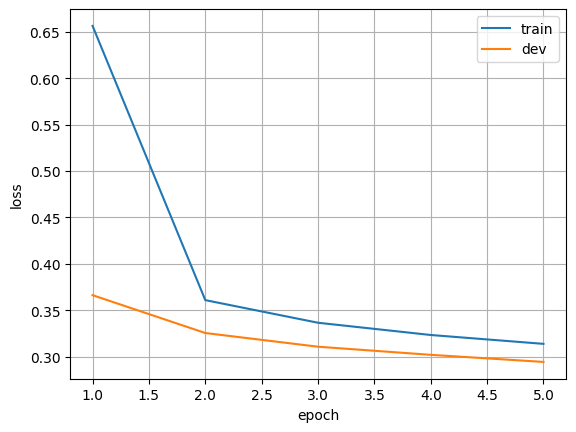

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline # importamos la libreria matplotlib

x = np.arange(n_epochs) + 1 # creamos un arreglo con el numero de epocas

plt.plot(x, train_loss) # graficamos la perdida de entrenamiento
plt.plot(x, dev_loss) # graficamos la perdida de validacion
plt.legend(['train', 'dev']) # agregamos la leyenda
plt.xlabel('epoch') # etiquetamos el eje x
plt.ylabel('loss') # etiquetamos el eje y
plt.grid(True) # agregamos una cuadricula

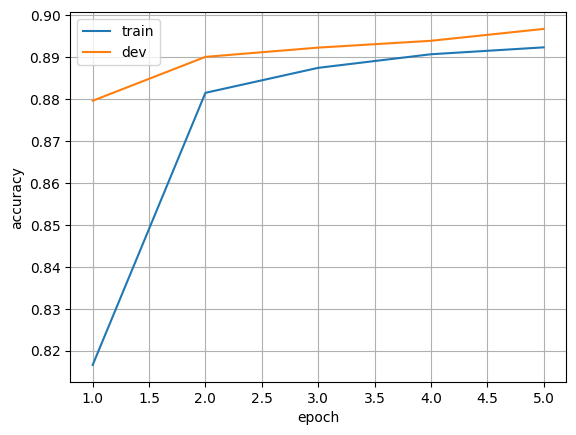

In [58]:
plt.plot(x, train_acc)
plt.plot(x, dev_acc)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

Next, we evaluate on the testing partition:

In [ ]:
# repeat all preprocessing done above, this time on the test set
test_df = pd.read_csv('./test.csv', header=None) # leemos el archivo test.csv
test_df.columns = ['class index', 'title', 'description'] # renombramos las columnas
test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower() # concatenamos las columnas 'title' y 'description'
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False) # reemplazamos los caracteres '\' por ' '
test_df['tokens'] = test_df['text'].progress_map(word_tokenize) # tokenizamos la columna 'text' y guardamos los tokens en la columna 'tokens'
max_tokens = dev_df['tokens'].map(len).max() # calculamos la longitud de la lista de tokens mas larga
test_df['token ids'] = test_df['tokens'].progress_map(token_ids) # mapeamos los tokens a sus ids y los guardamos en la columna 'token ids'

  0%|          | 0/7601 [00:00<?, ?it/s]

  0%|          | 0/7601 [00:00<?, ?it/s]

In [ ]:
test_df['class index'] = pd.to_numeric(test_df['class index'], errors='coerce') # convertimos la columna 'class index' a numerica
test_df = test_df.dropna(subset=['class index']).reset_index(drop=True) # eliminamos las filas con valores nulos en la columna 'class index'

In [63]:
from sklearn.metrics import classification_report

# set model to evaluation mode
model.eval()

dataset = MyDataset(test_df['token ids'], test_df['class index'] - 1)
data_loader = DataLoader(dataset, batch_size=batch_size)
y_pred = []

# don't store gradients
with torch.no_grad():
    for X, _ in tqdm(data_loader):
        X = X.to(device)
        # predict one class per example
        y = torch.argmax(model(X), dim=1)
        # convert tensor to numpy array (sending it back to the cpu if needed)
        y_pred.append(y.cpu().numpy())
        # print results
    print(classification_report(dataset.y, np.concatenate(y_pred), target_names=labels))

  0%|          | 0/16 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       World       0.93      0.88      0.90      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.85      0.85      0.85      1900
    Sci/Tech       0.86      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

